https://github.com/karpathy/micrograd/tree/master

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

In [14]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [101]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._backward = lambda: None
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__ (self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out
    
    def __radd__ (self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        return other + (-self)
    
    def __pow__(self, other) :
        assert isinstance(other, (int,float)), 'only supporting int/float'
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
            
        out._backward = _backward
        return out
        
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1) / (math.exp(2*n)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1  - t ** 2) * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited  = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()




In [ ]:
# manual backpropagtion example
a = Value(2, label='a')
b  = Value(3,label='b')
c= a*b
c.label='c'
d = Value(4, label = 'd')
e = c+d; e.label='e'
f = Value(2, label='f')
L = e*f; L.label='L'

# manual backpropagtion 

# L = f * e, e = c + d, c = a * b

# derivate of L w.r.t L, i.e. if we change L by tiny h how much will L change  dL / dL = 1
L.grad = 1.0

# derivate of L w.r.t f  = dL / df = e
f.grad = 10.0

# derivate of L w.r.t e  = dL / de = f
e.grad = 2.0

# derivate of L w.r.t c  = dL / dc > L to e and e to c > chain rule = dL / de * de / dc
c.grad = 2.0 * 1.0

# derivate of L w.r.t d  = dL / dd = dL / de * de / dd
d.grad = 2.0 * 1.0

# derivate of L w.r.t a  = dL / da = dL / dc * dc / da = dL / dc * b
a.grad = 2.0 * 3.0

# derivate of L w.r.t b  = dL / db = dL / dc * dc / db = dL / dc * a
b.grad = 2.0 * 2.0


# + op > distributes same value (chain rule applied) > c.grad == d.grad 
# * op > distributes other value as grad * grad of prev (chain rule applied) > grads of a and b
# same var used multiple times will need to accumulate the values hence += in all funcs > multivariate chain rule


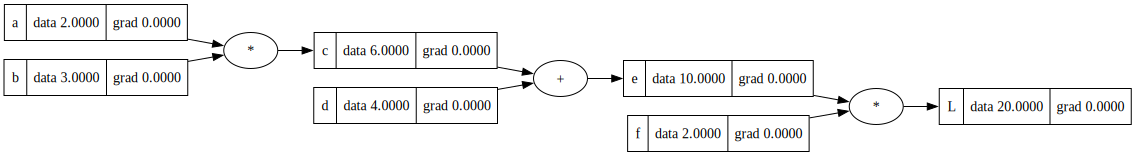

In [45]:
draw_dot(L)

In [63]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.88, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh() ; o.label = 'o'


In [40]:
# manual backprop grad
# do / do
o.grad = 1.0

# o = tanh n 
# do / dn  = 1 - tanh (o) ** 2 
# n.grad = 1  - o.data ** 2 
n.grad = 0.5

# sum (chain rule applied) disrtibutes same as seen above
x1w1x2w2.grad = 0.5 
b.grad = 0.5
x1w1.grad = 0.5 
x2w2.grad = 0.5

# mul distributes > alternate data * prev grad
x1.grad = w1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad

In [65]:
o.backward()

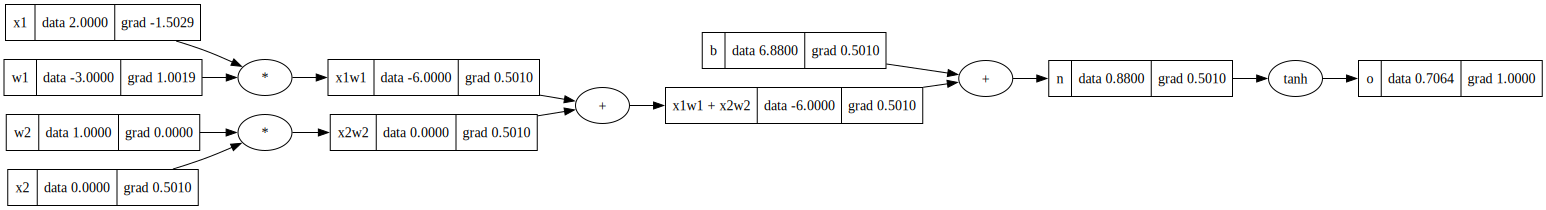

In [66]:
draw_dot(o)

In [1]:
# using pytorch
import torch

In [ ]:
#forward pass

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True

x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.88]).double() ; b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item()) # or print(o.item())

0.7064193777288968


In [ ]:
#backprop
o.backward()

In [8]:
print(x1.grad.item())
print(w1.grad.item())
print(x2.grad.item())
print(w2.grad.item())

-1.5029149883073543
1.0019433255382362
0.5009716627691181
0.0


In [9]:
import random

In [132]:
class Neuron:
    """
    nin = number of inputs to the neuron
    forward pass for a neuron with x inputs, w weights, b bias and tanh activation
    """
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    """
    class Layer is : list of neurons
    nin : number of inputs to a neuron
    nout : number of neurons in a layer
    """
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        """
        nin : number of inputs to a neuron
        nouts : list of size of each layer
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x= layer(x) 
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
x = [1,2,3]
n = MLP(3, [4,4,1])
n(x)
# draw_dot(n(x))

Value(data=-0.2995819435963075)

In [182]:
xs = [[2,3,-1],[3,0,1],[-1,0,2],[1,1,-1]]
ys = [1,-1,1,-1]

In [ ]:
for k in range(15):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yp-ygt)**2 for ygt, yp in zip(ys, ypred))
    
    # backward pass : gradient computation

    # zero grad : reset grad to 0 for each iteration to avoid accumulating it
    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.01 * p.grad
    
    print(k, loss.data)


0 0.0006765180838685782
1 0.0006761491005150876
2 0.0006757805437861552
3 0.0006754124129131911
4 0.0006750447071294886
5 0.0006746774256702616
6 0.0006743105677726028
7 0.0006739441326754735
8 0.0006735781196197268
9 0.0006732125278480777
10 0.0006728473566050989
11 0.0006724826051372214
12 0.0006721182726927356
13 0.0006717543585217751
14 0.0006713908618762915


In [184]:
ypred

[Value(data=0.9999997897419296),
 Value(data=-0.983785775582845),
 Value(data=0.9999966155513584),
 Value(data=-0.9797888699740038)]

In [185]:
n.parameters()

[Value(data=0.5288688101960296),
 Value(data=-1.7140088802665128),
 Value(data=-1.0425423456349139),
 Value(data=0.577501464930089),
 Value(data=0.6980399014844345),
 Value(data=0.06590307120032357),
 Value(data=-0.19500236346564873),
 Value(data=-0.4874026347517171),
 Value(data=-0.21272399674548192),
 Value(data=-1.0745607961815393),
 Value(data=0.05821530752207349),
 Value(data=0.5742879965586853),
 Value(data=-1.3473693253866355),
 Value(data=1.5277226539124071),
 Value(data=1.2612459139376755),
 Value(data=-0.6689252458361244),
 Value(data=0.910063809128875),
 Value(data=1.4927117546402913),
 Value(data=0.5383802465861356),
 Value(data=-0.2817818490929992),
 Value(data=-0.7219829679096617),
 Value(data=0.9279629727481087),
 Value(data=-0.08861704421828087),
 Value(data=1.3398267505513246),
 Value(data=-2.539892500819535),
 Value(data=-0.29415208471332377),
 Value(data=-1.2220560608558138),
 Value(data=-1.389676661986027),
 Value(data=0.42356833131036953),
 Value(data=0.42284958346